In [ ]:
# Install Library
!pip install feature_engine
!pip install catboost
!pip install optuna

In [ ]:
# Library untuk manipulasi data
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Library untuk timeseries analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.stattools import grangercausalitytests

# Library untuk feature engineering
from feature_engine.imputation import MeanMedianImputer
from feature_engine.timeseries.forecasting import WindowFeatures
from feature_engine.timeseries.forecasting import ExpandingWindowFeatures

# Library untuk machine learning
import optuna
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Library untuk deep learning
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

# Melakukan plot styling
color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

In [ ]:
# Membuat fungsi untuk melakukan preparation berdasarkan lokasi
def preparation_location(data1, data2, lokasi):
  df1 = data1[data1["Pintu Air"] == lokasi].copy()
  df2 = data2[data2["Pos Pantau"] == lokasi].copy()

  df1["Waktu"] = df1.index
  df2["Waktu"] = df2.index

  df1.reset_index(drop = True, inplace = True)
  df2.reset_index(drop = True, inplace = True)

  df = pd.merge(df1, df2, on = "Waktu", how = "outer")
  df.index = df["Waktu"]
  df.drop(["Waktu", "Pos Pantau"], axis = 1, inplace = True)

  df = df.asfreq("H")

  df["Pintu Air"].fillna(lokasi, inplace = True)

  return df

# Membuat fungsi untuk melakukan preparation dan penggabungan dataframe
def preparation(data1, data2):
  df1 = preparation_location(data1, data2, "Manggarai")
  df1 = window_features(df1)

  df2 = preparation_location(data1, data2, "Depok")
  df2 = window_features(df2)

  df3 = preparation_location(data1, data2, "Katulampa")
  df3 = window_features(df3)

  df4 = pd.concat([df1, df2], axis = 0)
  df = pd.concat([df4, df3], axis = 0)

  df = df.sort_values(ascending = True, by = "Waktu")

  return df

# Membuat fungsi untuk create feature lag
def create_lags(df, feature, lags = [1]):
    dummy = pd.DataFrame(df[feature])
    for i in lags:
        dummy[feature + "_lag_" + str(i)] = dummy[feature].shift(i)
    return dummy

# Membuat fungsi untuk melakukan feature engineering
def create_features(df, lag_features = [], lags = [[1]]):
  # Membuat timseries features
  df["hour"] = df.index.hour
  df["dayofweek"] = df.index.dayofweek
  df["dayofyear"] = df.index.dayofyear
  df["dayofmonth"] = df.index.day
  df["week"] = df.index.week
  df["quarter"] = df.index.quarter
  df["month"] = df.index.month
  df["year"] = df.index.year

  # Membuat feature lags
  for i, j in enumerate(lag_features):
    dummy = create_lags(df, j, lags[i])
    dummy.drop(j, axis = 1, inplace = True)
    df = pd.concat([df, dummy], axis = 1)

  return df

# Membuat fungsi window features
def window_features(df):
  # Membuat window features
  win_f = WindowFeatures(variables = ["Tinggi Air", "Intensitas"], window = [6, 12, 18, 24],
                         functions = ["mean", "min", "max", "std"], missing_values = "ignore")
  df = win_f.fit_transform(df)

  # Membuat expanding window features
  win_f = ExpandingWindowFeatures(variables = ["Tinggi Air", "Intensitas"],
                                  functions = ["mean", "min", "max", "std"], missing_values = "ignore")
  df = win_f.fit_transform(df)

  return df

# Membuat fungsi untuk melakukan augmented dickey fuller test
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [ ]:
os.chdir("/content/drive/MyDrive/STARCORE2023")

# Problem Understanding

*   Keempat tempat yaitu Katulampa, Depok, Manggarai, dan Marina Ancol berada pada jalur sungai Ciliwung
*   Perlu diingat bahwa Marina Ancol ada tinggi muka air laut bukan sungai
*   Curah hujan satuannya dalam mm, akumulasi dalam satu jam ke depan
*   Data berasal dari catatan IOT
*   Tinggi muka air adalah point/data sesaat bukan akumulasi
*   Metric kemungkinan besar adalah RMSE



# Data Understanding

In [ ]:
# Read data train
train_curah = pd.read_excel("Salinan train_Curah hujan 2021-2022.xlsx")
train_tma = pd.read_excel("Salinan train_TMA Ciliwung 2021-2022.xlsx")

# Read data test
test_curah = pd.read_excel("Salinan test_Curah hujan 2023.xlsx")
test_tma = pd.read_excel("Salinan test_TMA Ciliwung 2023-2.xlsx")

# Read file submission
sub = pd.read_csv("Salinan submission.csv")

## Training Set Curah

In [ ]:
train_curah.head()

,Pos Pantau,Waktu,Intensitas
0,Balekambang,2021-11-21 08:00:00,0
1,Balekambang,2021-11-21 09:00:00,0
2,Balekambang,2021-11-21 19:00:00,0
3,Balekambang,2021-11-21 20:00:00,0
4,Balekambang,2021-11-21 21:00:00,0


In [ ]:
# Melakukan pengecekan jumlah baris dan kolom
train_curah.shape

(211238, 3)

In [ ]:
# Melakukan pengecekan baris duplikat
train_curah.duplicated(subset = ["Pos Pantau", "Waktu"]).sum()

0

In [ ]:
# Melakukan reindexing dan pengubahan data type waktu menjadi datetime
# Kemudian melakukan drop kolom Waktu
train_curah.index = pd.to_datetime(train_curah["Waktu"])
train_curah.drop(["Waktu"], axis = 1, inplace = True)

In [ ]:
# Melakukan pengecekan statistik deskriptif variabel kategorik
train_curah.describe(include = "object")

,Pos Pantau
count,211238
unique,18
top,Manggarai
freq,17069


In [ ]:
# Melakukan pengecekan statistik deskriptif variabel numerik
train_curah.describe(exclude = "object")

,Intensitas
count,211238.000000
mean,27.389580
std,108.510682
min,0.000000
25%,0.000000
50%,0.000000
75%,6.000000
max,17449.000000


In [ ]:
# Melakukan pengecekan missing values
train_curah.isnull().sum()

Pos Pantau    0
Intensitas    0
dtype: int64

In [ ]:
# Melihat distribusi data berdasarkan Pos Pantau
train_curah["Pos Pantau"].value_counts()

Manggarai           17069
Marina Ancol        16926
Depok               16645
Pluit               16193
Katulampa           15250
Pasar Ikan          14517
Ciganjur            13268
Balekambang          9558
Bojong Murni         9482
Pasar Minggu         9391
Mampang Prapatan     9364
Jembatan Merah       9361
Bukit Duri           9352
Pekayon              9291
Pancoran Mas         9107
Cilangkap            9094
Megamendung          8773
Pela Mampang         8597
Name: Pos Pantau, dtype: int64

In [ ]:
# Mengambil data dengan Pos Pantau di Manggarai, Depok, Marina Ancol, dan Katulampa
train_curah = train_curah[train_curah["Pos Pantau"].isin(["Manggarai", "Depok", "Marina Ancol", "Katulampa"])]

<ipython-input-9-c56b6e5f78bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_curah["Intensitas"])


<Axes: xlabel='Intensitas', ylabel='Density'>

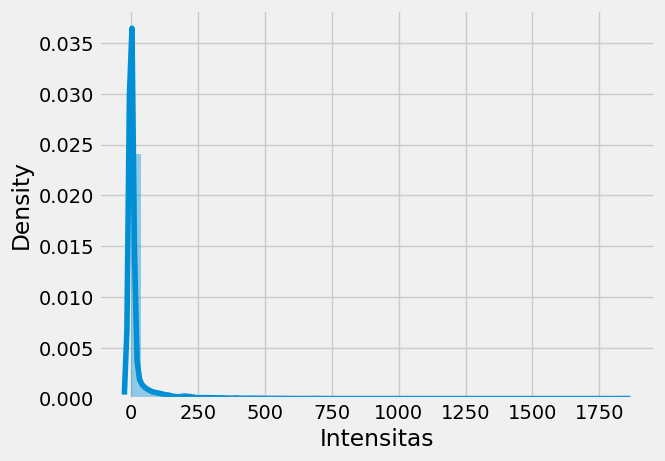

In [ ]:
# Melakukan visualisasi Intensitas
sns.distplot(train_curah["Intensitas"])

<ipython-input-167-619d61061898>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(train_curah["Intensitas"]))


<Axes: xlabel='Intensitas', ylabel='Density'>

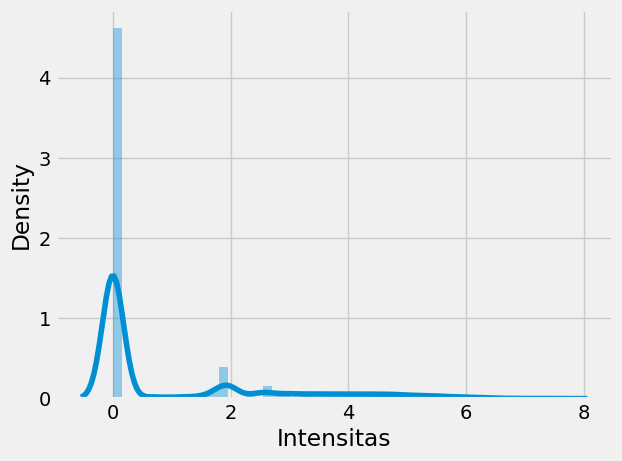

In [ ]:
# Melakukan visualisasi Intensitas dengan mengambil log-nya
sns.distplot(np.log1p(train_curah["Intensitas"]))

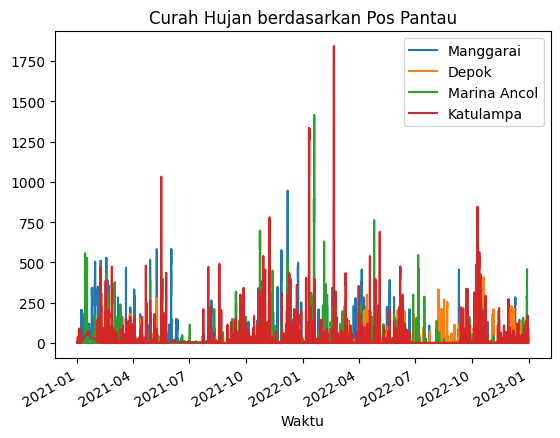

In [ ]:
# Melakukan visualisasi tinggi air berdasarkan pintu air
train_curah[train_curah["Pos Pantau"] == "Manggarai"]["Intensitas"].plot(kind = "line", label = "Manggarai")
train_curah[train_curah["Pos Pantau"] == "Depok"]["Intensitas"].plot(kind = "line", label = "Depok")
train_curah[train_curah["Pos Pantau"] == "Marina Ancol"]["Intensitas"].plot(kind = "line", label = "Marina Ancol")
train_curah[train_curah["Pos Pantau"] == "Katulampa"]["Intensitas"].plot(kind = "line", label = "Katulampa")
plt.title("Curah Hujan berdasarkan Pos Pantau")
plt.legend()

<Axes: xlabel='Pos Pantau', ylabel='Intensitas'>

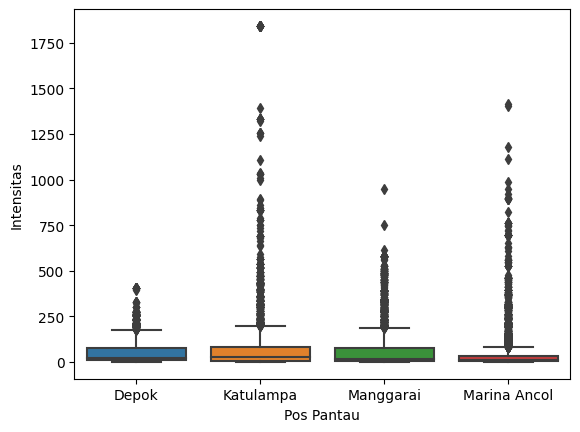

In [ ]:
# Melakukan visualisasi curah hujan tiap Pos Pantau
sns.boxplot(x = "Pos Pantau", y = "Intensitas", data = train_curah[train_curah["is_rain"] == 1])

In [ ]:
# Mendapatkan dataframe berdasarkan pintu air
manggarai = train_curah[train_curah["Pos Pantau"] == "Manggarai"]
depok = train_curah[train_curah["Pos Pantau"] == "Depok"]
marina = train_curah[train_curah["Pos Pantau"] == "Marina Ancol"]
katulampa = train_curah[train_curah["Pos Pantau"] == "Katulampa"]

In [ ]:
timestamp_s = manggarai.index.map(pd.Timestamp.timestamp)

In [ ]:
timestamp_s = manggarai.index.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

manggarai['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
manggarai['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
manggarai['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
manggarai['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

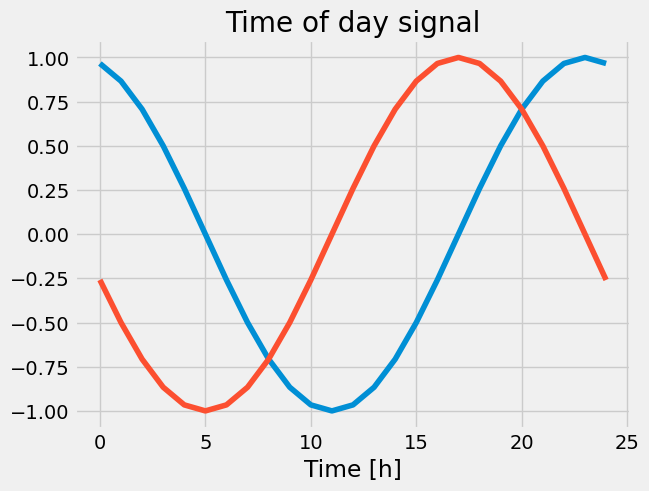

In [ ]:
plt.plot(np.array(manggarai['Day sin'])[:25])
plt.plot(np.array(manggarai['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

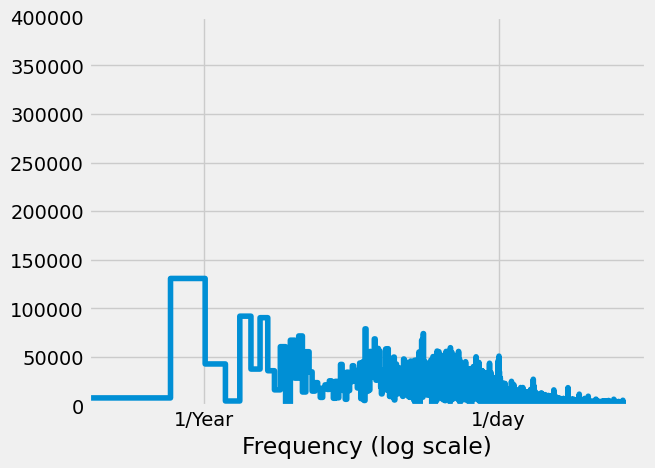

In [ ]:
fft = tf.signal.rfft(manggarai['Intensitas'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(manggarai['Intensitas'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

<ipython-input-10-aa6f1a4a685e>:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Pos Pantau'], dtype='object')
  moving_average = manggarai.rolling(window = 24*30, center = True, min_periods = 24*15).mean()


<Axes: title={'center': 'Intensitas 24 hour Moving Average'}, xlabel='Waktu'>

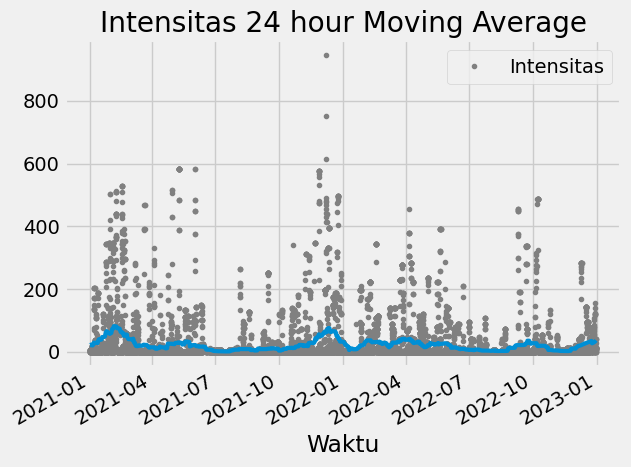

In [ ]:
moving_average = manggarai.rolling(window = 24*30, center = True, min_periods = 24*15).mean()
ax = manggarai.plot(style = ".", color = "0.5")
moving_average.plot(ax = ax, linewidth = 3, legend = False, title = "Intensitas 24 hour Moving Average")

<ipython-input-18-3422c0a2f484>:57: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

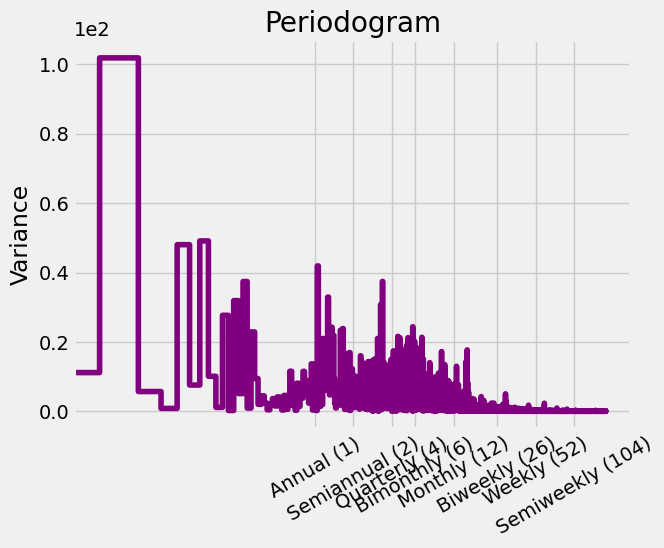

In [ ]:
plot_periodogram(manggarai["Intensitas"])

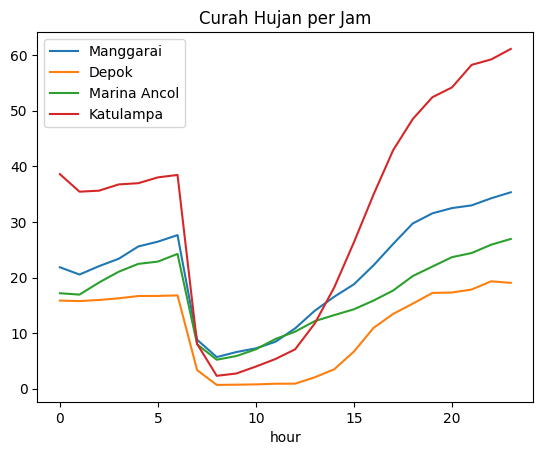

In [ ]:
# Melakukan visualisasi curah hujan per jam
manggarai.groupby("hour")["Intensitas"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("hour")["Intensitas"].mean().plot(kind = "line", label = "Depok")
marina.groupby("hour")["Intensitas"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("hour")["Intensitas"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Curah Hujan per Jam")
plt.legend()

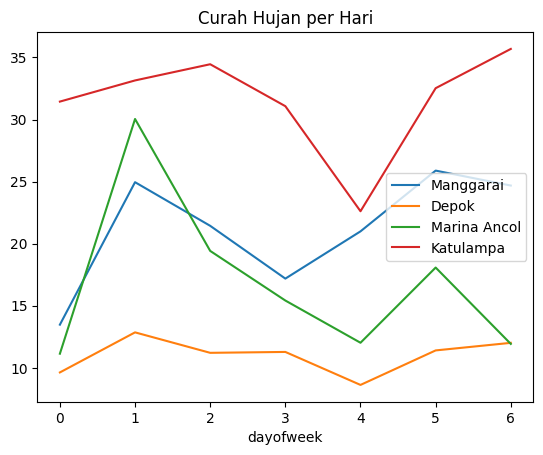

In [ ]:
# Melakukan visualisasi curah hujan per hari
manggarai.groupby("dayofweek")["Intensitas"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("dayofweek")["Intensitas"].mean().plot(kind = "line", label = "Depok")
marina.groupby("dayofweek")["Intensitas"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("dayofweek")["Intensitas"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Curah Hujan per Hari")
plt.legend()

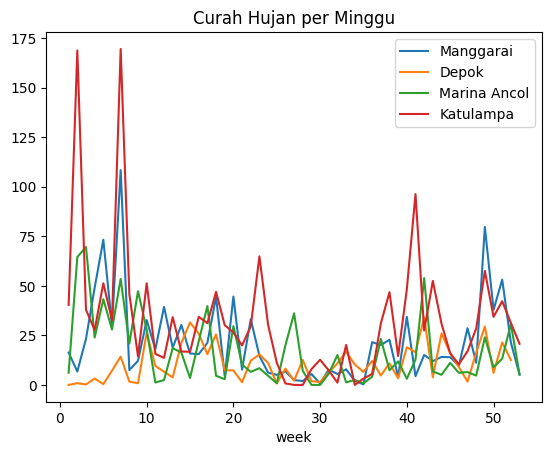

In [ ]:
# Melakukan visualisasi curah hujan per minggu
manggarai.groupby("week")["Intensitas"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("week")["Intensitas"].mean().plot(kind = "line", label = "Depok")
marina.groupby("week")["Intensitas"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("week")["Intensitas"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Curah Hujan per Minggu")
plt.legend()

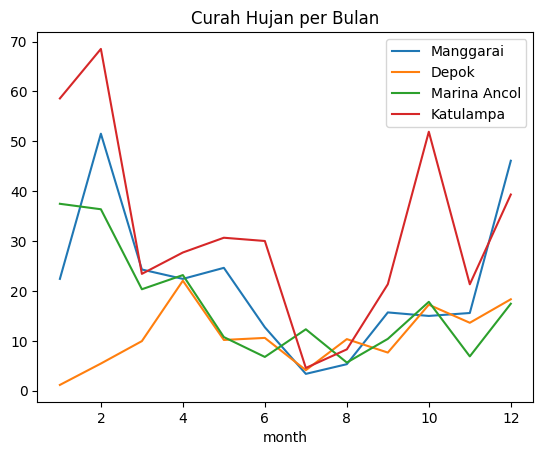

In [ ]:
# Melakukan visualisasi curah hujan per bulan
manggarai.groupby("month")["Intensitas"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("month")["Intensitas"].mean().plot(kind = "line", label = "Depok")
marina.groupby("month")["Intensitas"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("month")["Intensitas"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Curah Hujan per Bulan")
plt.legend()

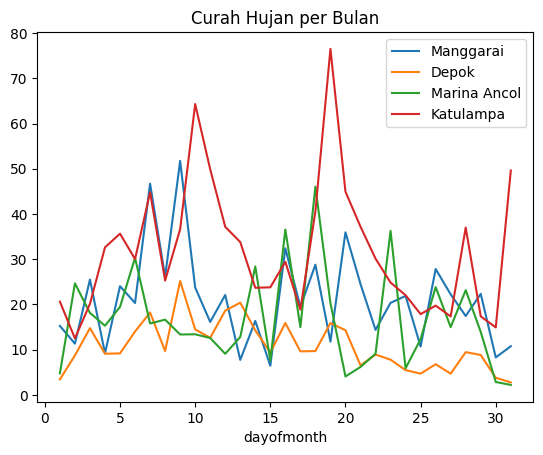

In [ ]:
# Melakukan visualisasi curah hujan per bulan
manggarai.groupby("dayofmonth")["Intensitas"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("dayofmonth")["Intensitas"].mean().plot(kind = "line", label = "Depok")
marina.groupby("dayofmonth")["Intensitas"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("dayofmonth")["Intensitas"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Curah Hujan per Bulan")
plt.legend()

## Training Set TMA

In [ ]:
train_tma.head()

,Waktu,Pintu Air,Tinggi Air
0,2021-01-01 01:00:00,Depok,82.0
1,2021-01-01 01:00:00,Katulampa,27.0
2,2021-01-01 01:00:00,Manggarai,530.0
3,2021-01-01 01:00:00,Manggarai,528.0
4,2021-01-01 01:00:00,Marina Ancol,165.0


In [ ]:
train_tma.shape

(72068, 3)

In [ ]:
# Melakukan pengecekan baris duplikat
train_tma.duplicated(subset = ["Waktu", "Pintu Air"]).sum()

1992

In [ ]:
# Melakukan penghapusan baris duplikat
train_tma.drop_duplicates(subset = ["Waktu", "Pintu Air"], inplace = True)
train_tma.reset_index(drop = True, inplace = True)

In [ ]:
# Melakukan reindexing dan pengubahan data type waktu menjadi datetime
# Kemudian melakukan drop kolom Waktu
train_tma.index = pd.to_datetime(train_tma["Waktu"])
train_tma.drop(["Waktu"], axis = 1, inplace = True)

In [ ]:
# Melakukan pengecekan statistik deskriptif variabel kategorik
train_tma.describe(include = "object")

,Pintu Air
count,70076
unique,4
top,Depok
freq,17519


In [ ]:
# Melakukan pengecekan distribusi data berdasarkan Pintu Air
train_tma["Pintu Air"].value_counts()

Depok           17519
Katulampa       17519
Manggarai       17519
Marina Ancol    17519
Name: Pintu Air, dtype: int64

In [ ]:
# Melakukan pengecekan statistik deskriptif variabel numerik
train_tma.describe(exclude = "object")

,Tinggi Air
count,67538.000000
mean,232.173947
std,232.897145
min,-32.000000
25%,65.000000
50%,144.000000
75%,266.000000
max,6300.000000


In [ ]:
# Melakukan pengecekan missing values
train_tma.isnull().sum()

Pintu Air        0
Tinggi Air    2538
dtype: int64

In [ ]:
# Melakukan pengecekan outliers
train_tma[train_tma["Tinggi Air"] > 1000]

,Pintu Air,Tinggi Air
Waktu,,
2021-01-06 05:00:00,Manggarai,5353.0
2021-04-18 12:00:00,Manggarai,6300.0


In [ ]:
train_tma[(train_tma["Tinggi Air"] < 0)].head(50)

In [ ]:
# Melakukan penanganan outliers
train_tma["Tinggi Air"] = np.abs(train_tma["Tinggi Air"])
train_tma = train_tma[(train_tma["Tinggi Air"] > 0) & (train_tma["Tinggi Air"] < 1000)]

<ipython-input-14-a54e2e7b565c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_tma["Tinggi Air"])


<Axes: xlabel='Tinggi Air', ylabel='Density'>

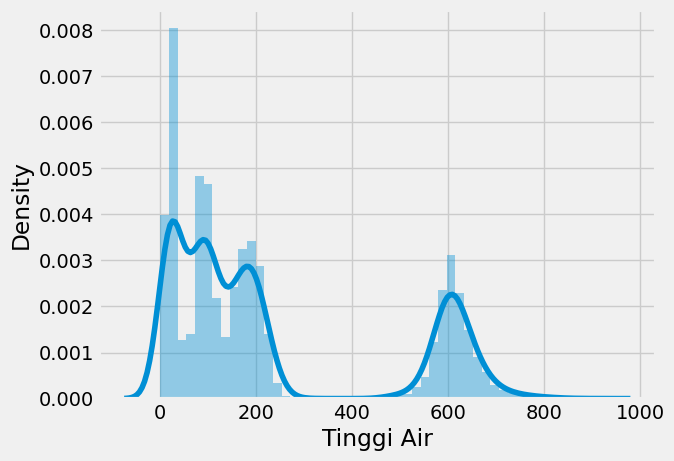

In [ ]:
# Melakukan visualisasi tinggi muka air
sns.distplot(train_tma["Tinggi Air"])

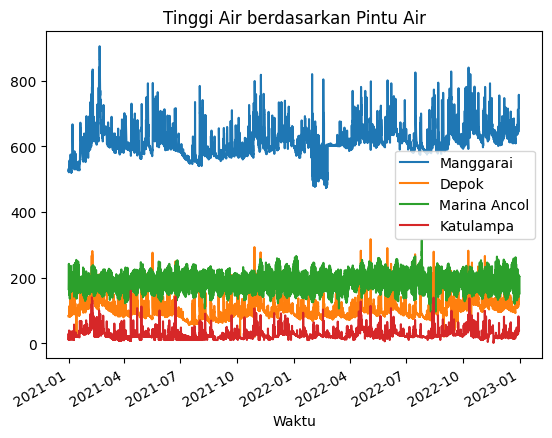

In [ ]:
# Melakukan visualisasi tinggi air berdasarkan pintu air
train_tma[train_tma["Pintu Air"] == "Manggarai"]["Tinggi Air"].plot(kind = "line", label = "Manggarai")
train_tma[train_tma["Pintu Air"] == "Depok"]["Tinggi Air"].plot(kind = "line", label = "Depok")
train_tma[train_tma["Pintu Air"] == "Marina Ancol"]["Tinggi Air"].plot(kind = "line", label = "Marina Ancol")
train_tma[train_tma["Pintu Air"] == "Katulampa"]["Tinggi Air"].plot(kind = "line", label = "Katulampa")
plt.title("Tinggi Air berdasarkan Pintu Air")
plt.legend()

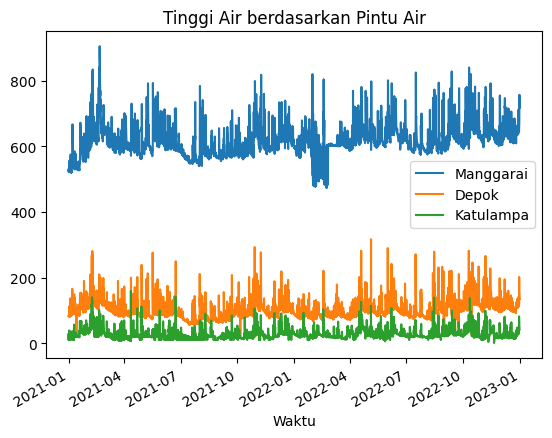

In [ ]:
# Melakukan visualisasi tinggi air berdasarkan pintu air
train_tma[train_tma["Pintu Air"] == "Manggarai"]["Tinggi Air"].plot(kind = "line", label = "Manggarai")
train_tma[train_tma["Pintu Air"] == "Depok"]["Tinggi Air"].plot(kind = "line", label = "Depok")
train_tma[train_tma["Pintu Air"] == "Katulampa"]["Tinggi Air"].plot(kind = "line", label = "Katulampa")
plt.title("Tinggi Air berdasarkan Pintu Air")
plt.legend()

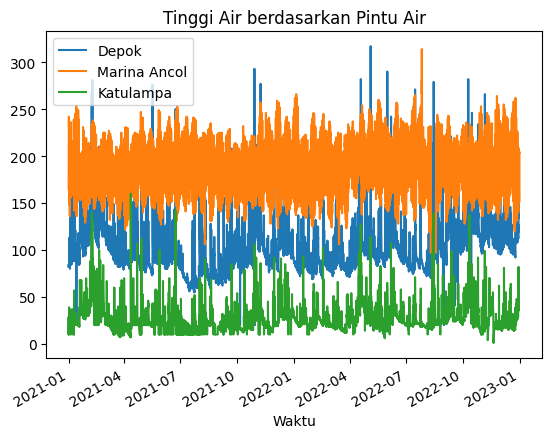

In [ ]:
# Melakukan visualisasi tinggi air berdasarkan pintu air
train_tma[train_tma["Pintu Air"] == "Depok"]["Tinggi Air"].plot(kind = "line", label = "Depok")
train_tma[train_tma["Pintu Air"] == "Marina Ancol"]["Tinggi Air"].plot(kind = "line", label = "Marina Ancol")
train_tma[train_tma["Pintu Air"] == "Katulampa"]["Tinggi Air"].plot(kind = "line", label = "Katulampa")
plt.title("Tinggi Air berdasarkan Pintu Air")
plt.legend()

Text(0.5, 1.0, 'Tinggi Air pada Pintu Air Manggarai')

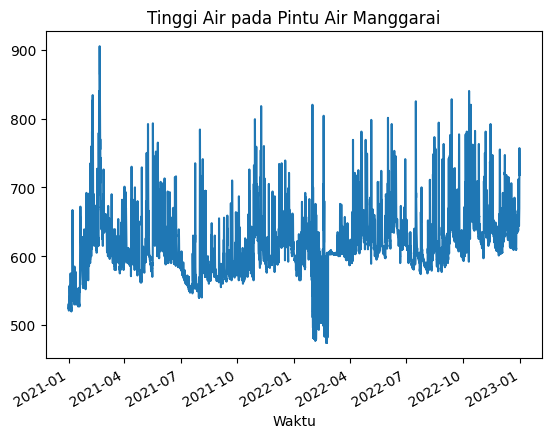

In [ ]:
# Melakukan visualisasi tinggi air Manggarai
train_tma[train_tma["Pintu Air"] == "Manggarai"]["Tinggi Air"].plot(kind = "line", label = "Manggarai")
plt.title("Tinggi Air pada Pintu Air Manggarai")

In [ ]:
# Melakukan scaling features
scaler = MinMaxScaler()
train_tma_scaled = pd.DataFrame(scaler.fit_transform(train_tma[['Tinggi Air']]),
                                columns = ['Tinggi Air'])
train_tma_scaled["Pintu Air"] = train_tma["Pintu Air"].reset_index(drop = True)
train_tma_scaled.index = train_tma.index
train_tma_scaled[['hour', 'dayofweek', 'dayofyear', 'week', 'month', 'year']] = train_tma[['hour', 'dayofweek', 'dayofyear', 'week', 'month', 'year']]

# Mendapatkan dataframe berdasarkan pintu air
manggarai = train_tma_scaled[train_tma_scaled["Pintu Air"] == "Manggarai"]
depok = train_tma_scaled[train_tma_scaled["Pintu Air"] == "Depok"]
marina = train_tma_scaled[train_tma_scaled["Pintu Air"] == "Marina Ancol"]
katulampa = train_tma_scaled[train_tma_scaled["Pintu Air"] == "Katulampa"]

In [ ]:
# Mendapatkan dataframe berdasarkan pintu air
manggarai = train_tma[train_tma["Pintu Air"] == "Manggarai"]
depok = train_tma[train_tma["Pintu Air"] == "Depok"]
marina = train_tma[train_tma["Pintu Air"] == "Marina Ancol"]
katulampa = train_tma[train_tma["Pintu Air"] == "Katulampa"]
locations = []

for i in [manggarai, depok, marina, katulampa]:
  scaler = MinMaxScaler()
  df = pd.DataFrame(scaler.fit_transform(i[["Tinggi Air"]]), columns = ["Tinggi Air"])
  df[['hour', 'dayofweek', 'dayofyear', 'week', 'month', 'year']] = i[['hour', 'dayofweek', 'dayofyear', 'week', 'month', 'year']].reset_index(drop = True)
  df.index = i.index
  locations.append(df)

manggarai = locations[0]
depok = locations[1]
marina = locations[2]
katulampa = locations[3]

In [ ]:
# Mendapatkan dataframe berdasarkan pintu air
manggarai = train_tma[train_tma["Pintu Air"] == "Manggarai"]
depok = train_tma[train_tma["Pintu Air"] == "Depok"]
marina = train_tma[train_tma["Pintu Air"] == "Marina Ancol"]
katulampa = train_tma[train_tma["Pintu Air"] == "Katulampa"]

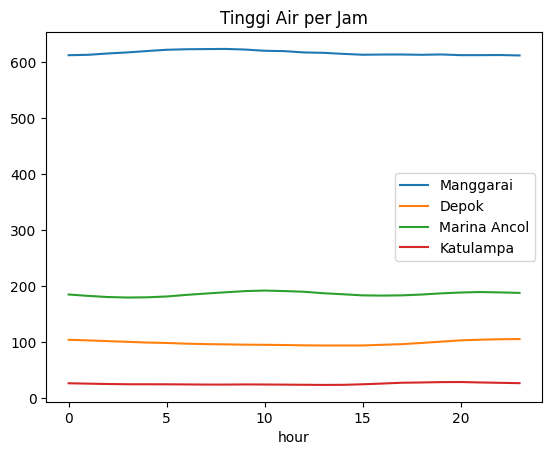

In [ ]:
# Melakukan visualisasi ketinggian air per jam
manggarai.groupby("hour")["Tinggi Air"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("hour")["Tinggi Air"].mean().plot(kind = "line", label = "Depok")
marina.groupby("hour")["Tinggi Air"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("hour")["Tinggi Air"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Tinggi Air per Jam")
plt.legend()

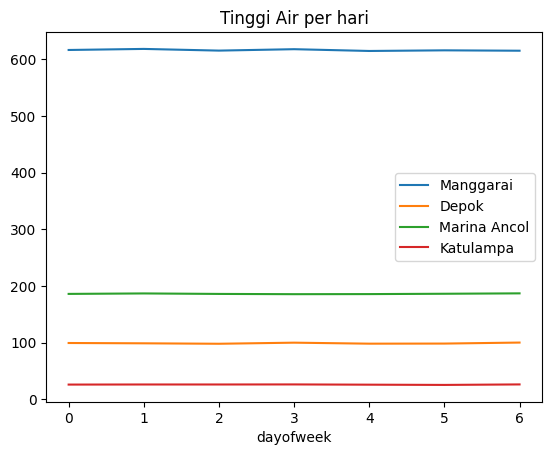

In [ ]:
# Melakukan visualisasi ketinggian air per hari
manggarai.groupby("dayofweek")["Tinggi Air"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("dayofweek")["Tinggi Air"].mean().plot(kind = "line", label = "Depok")
marina.groupby("dayofweek")["Tinggi Air"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("dayofweek")["Tinggi Air"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Tinggi Air per hari")
plt.legend()

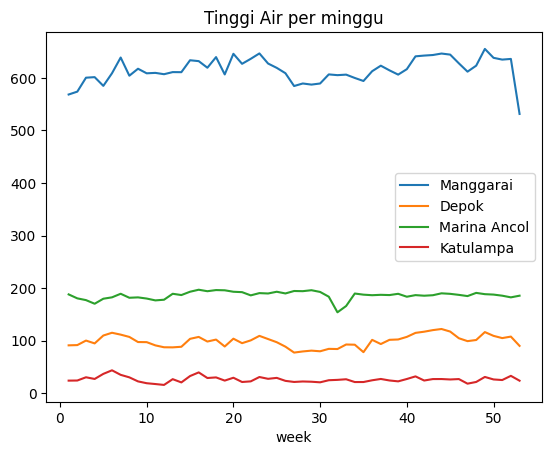

In [ ]:
# Melakukan visualisasi ketinggian air per minggu
manggarai.groupby("week")["Tinggi Air"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("week")["Tinggi Air"].mean().plot(kind = "line", label = "Depok")
marina.groupby("week")["Tinggi Air"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("week")["Tinggi Air"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Tinggi Air per minggu")
plt.legend()

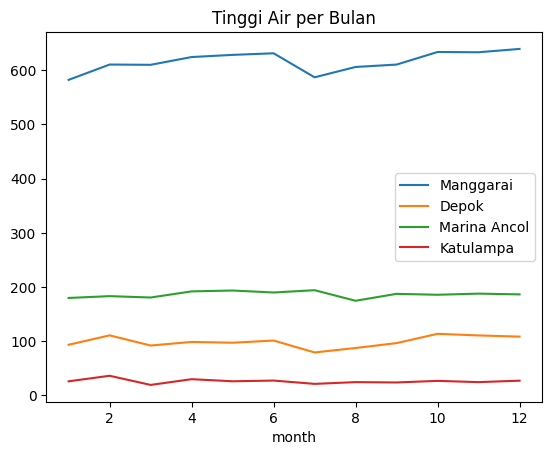

In [ ]:
# Melakukan visualisasi ketinggian air per bulan
manggarai.groupby("month")["Tinggi Air"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("month")["Tinggi Air"].mean().plot(kind = "line", label = "Depok")
marina.groupby("month")["Tinggi Air"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("month")["Tinggi Air"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Tinggi Air per Bulan")
plt.legend()

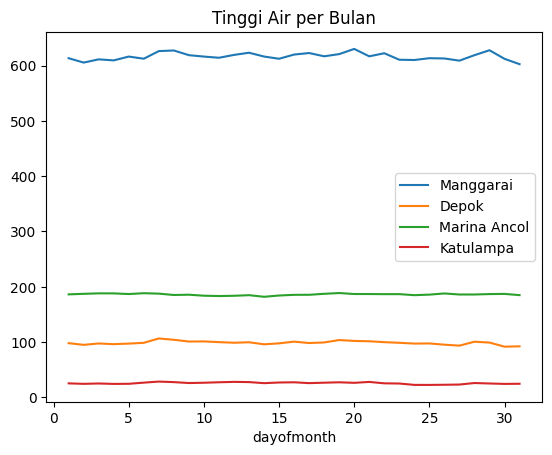

In [ ]:
# Melakukan visualisasi ketinggian air per bulan
manggarai.groupby("dayofmonth")["Tinggi Air"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("dayofmonth")["Tinggi Air"].mean().plot(kind = "line", label = "Depok")
marina.groupby("dayofmonth")["Tinggi Air"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("dayofmonth")["Tinggi Air"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Tinggi Air per Bulan")
plt.legend()

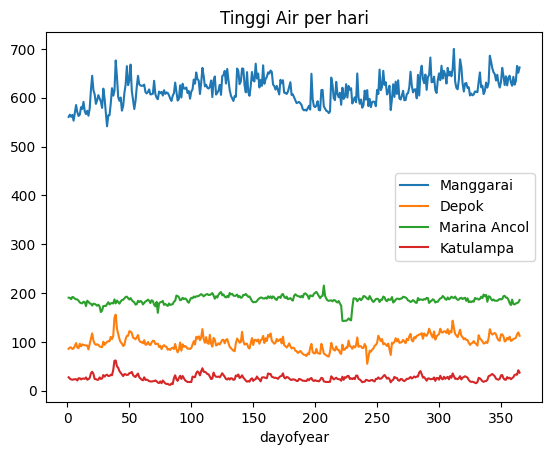

In [ ]:
# Melakukan visualisasi ketinggian air per hari
manggarai.groupby("dayofyear")["Tinggi Air"].mean().plot(kind = "line", label = "Manggarai")
depok.groupby("dayofyear")["Tinggi Air"].mean().plot(kind = "line", label = "Depok")
marina.groupby("dayofyear")["Tinggi Air"].mean().plot(kind = "line", label = "Marina Ancol")
katulampa.groupby("dayofyear")["Tinggi Air"].mean().plot(kind = "line", label = "Katulampa")
plt.title("Tinggi Air per hari")
plt.legend()

## Testing Set Curah

In [ ]:
test_curah.head()

,Pos Pantau,Waktu,Intensitas
0,Balekambang,2023-01-01 07:00:00,8
1,Balekambang,2023-01-01 08:00:00,12
2,Balekambang,2023-01-01 09:00:00,12
3,Balekambang,2023-01-01 10:00:00,12
4,Balekambang,2023-01-01 11:00:00,12


In [ ]:
test_curah.shape

(24308, 3)

In [ ]:
# Melihat distribusi data berdasarkan Pos Pantau
test_curah["Pos Pantau"].value_counts()

Balekambang         1409
Bukit Duri          1409
Pasar Minggu        1409
Cilangkap           1409
Pasar Ikan          1409
Pancoran Mas        1409
Megamendung         1409
Mampang Prapatan    1409
Marina Ancol        1408
Bojong Murni        1408
Manggarai           1402
Katulampa           1400
Pela Mampang        1400
Depok               1396
Pekayon             1393
Jembatan Merah      1287
Pluit               1160
Ciganjur             782
Name: Pos Pantau, dtype: int64

In [ ]:
test_curah = test_curah[test_curah["Pos Pantau"].isin(["Manggarai", "Depok", "Katulampa", "Marina Ancol"])].reset_index(drop = True)

In [ ]:
test_curah.index = pd.to_datetime(test_curah["Waktu"])
test_curah.drop("Waktu", axis = 1, inplace = True)

In [ ]:
test_curah

,Pos Pantau,Intensitas
Waktu,,
2023-01-01 07:00:00,Depok,2
2023-01-01 08:00:00,Depok,0
2023-01-01 09:00:00,Depok,13
2023-01-01 10:00:00,Depok,18
2023-01-01 11:00:00,Depok,18
...,...,...
2023-02-28 19:00:00,Marina Ancol,60
2023-02-28 20:00:00,Marina Ancol,60
2023-02-28 21:00:00,Marina Ancol,60


## Testing Set TMA

In [ ]:
test_tma.head()

,Waktu,Pintu Air,Tinggi Air,ID,Prediksi 6 Jam Ke Depan
0,2023-01-01 00:00:00,Depok,100.0,1,NaN
1,2023-01-01 00:00:00,Katulampa,20.0,2,NaN
2,2023-01-01 00:00:00,Manggarai,635.0,3,NaN
3,2023-01-01 00:00:00,Marina Ancol,159.0,4,NaN
4,2023-01-01 01:00:00,Depok,133.0,5,NaN


In [ ]:
test_tma = test_tma[test_tma["Pintu Air"].isin(["Manggarai", "Depok", "Katulampa", "Marina Ancol"])].reset_index(drop = True)

In [ ]:
test_tma.index = pd.to_datetime(test_tma["Waktu"])
test_tma.drop("Waktu", axis = 1, inplace = True)

## Submission

In [ ]:
sub = pd.read_csv("Salinan submission.csv")

In [ ]:
sub.head()

,ID,Prediksi 6 Jam Ke Depan
0,1,NaN
1,2,NaN
2,3,NaN
3,5,NaN
4,6,NaN


In [ ]:
sub.shape

(4248, 2)

In [ ]:
sub.drop(["Prediksi 6 Jam Ke Depan"], axis = 1, inplace = True)

# Data Preparation

In [ ]:
train = preparation(train_tma, train_curah)
test = preparation(test_tma, test_curah)

In [ ]:
train["Pintu Air"].value_counts()

Manggarai    17503
Depok        17503
Katulampa    17503
Name: Pintu Air, dtype: int64

In [ ]:
test["Pintu Air"].value_counts()

Manggarai    1416
Katulampa    1416
Depok        1416
Name: Pintu Air, dtype: int64

In [ ]:
# Melakukan feature engineering dan penggabungan dataframe untuk training set
df = create_features(train[train["Pintu Air"] == "Katulampa"], lag_features = ["Tinggi Air", "Intensitas"], lags = [[1, 2], [1, 2]])
marina = preparation_location(train_tma, train_curah, "Marina Ancol").iloc[:-16, :].rename(columns = {"Tinggi Air":"Tinggi Air_Marina", "Intensitas":"Intensitas_Marina"})
marina.drop(["Pintu Air"], axis = 1, inplace = True)
df = pd.concat([df, marina], axis = 1)

for i in ["Depok", "Manggarai"]:
  dummy = create_features(train[train["Pintu Air"] == i], lag_features = ["Tinggi Air", "Intensitas"], lags = [[1, 2], [1, 2]])
  marina = preparation_location(train_tma, train_curah, "Marina Ancol").iloc[:-16, :].rename(columns = {"Tinggi Air":"Tinggi Air_Marina", "Intensitas":"Intensitas_Marina"})
  marina.drop(["Pintu Air"], axis = 1, inplace = True)
  dummy = pd.concat([dummy, marina], axis = 1)
  df = pd.concat([df, dummy], axis = 0)

In [ ]:
# Melakukan feature engineering dan penggabungan dataframe untuk training set
df = create_features(train[train["Pintu Air"] == "Katulampa"])
marina = preparation_location(train_tma, train_curah, "Marina Ancol").iloc[:-16, :].rename(columns = {"Tinggi Air":"Tinggi Air_Marina", "Intensitas":"Intensitas_Marina"})
marina.drop(["Pintu Air"], axis = 1, inplace = True)
df = pd.concat([df, marina], axis = 1)

for i in ["Depok", "Manggarai"]:
  dummy = create_features(train[train["Pintu Air"] == i])
  marina = preparation_location(train_tma, train_curah, "Marina Ancol").iloc[:-16, :].rename(columns = {"Tinggi Air":"Tinggi Air_Marina", "Intensitas":"Intensitas_Marina"})
  marina.drop(["Pintu Air"], axis = 1, inplace = True)
  dummy = pd.concat([dummy, marina], axis = 1)
  df = pd.concat([df, dummy], axis = 0)

In [ ]:
# Melakukan feature engineering dan penggabungan dataframe untuk testing set
dfs = create_features(test[test["Pintu Air"] == "Katulampa"], lag_features = ["Tinggi Air", "Intensitas"], lags = [[1, 2], [1, 2]])
marina = preparation_location(test_tma, test_curah, "Marina Ancol").iloc[:-16, :].rename(columns = {"Tinggi Air":"Tinggi Air_Marina", "Intensitas":"Intensitas_Marina"})
marina.drop(["Pintu Air"], axis = 1, inplace = True)
dfs = pd.concat([dfs, marina], axis = 1)

for i in ["Depok", "Manggarai"]:
  dummy = create_features(test[test["Pintu Air"] == i], lag_features = ["Tinggi Air", "Intensitas"], lags = [[1, 2], [1, 2]])
  marina = preparation_location(test_tma, test_curah, "Marina Ancol").iloc[:-16, :].rename(columns = {"Tinggi Air":"Tinggi Air_Marina", "Intensitas":"Intensitas_Marina"})
  marina.drop(["Pintu Air"], axis = 1, inplace = True)
  dummy = pd.concat([dummy, marina], axis = 1)
  dfs = pd.concat([dfs, dummy], axis = 0)

sub_preds = dfs[["Tinggi Air", "ID", "Prediksi 6 Jam Ke Depan"]].iloc[:, 0:2]
dfs.drop(["ID", "Prediksi 6 Jam Ke Depan"], axis = 1, inplace = True)
dfs.reset_index(drop = True, inplace = True)

In [ ]:
# Melakukan feature engineering dan penggabungan dataframe untuk testing set
dfs = create_features(test[test["Pintu Air"] == "Katulampa"])
marina = preparation_location(test_tma, test_curah, "Marina Ancol").iloc[:-16, :].rename(columns = {"Tinggi Air":"Tinggi Air_Marina", "Intensitas":"Intensitas_Marina"})
marina.drop(["Pintu Air"], axis = 1, inplace = True)
dfs = pd.concat([dfs, marina], axis = 1)

for i in ["Depok", "Manggarai"]:
  dummy = create_features(test[test["Pintu Air"] == i])
  marina = preparation_location(test_tma, test_curah, "Marina Ancol").iloc[:-16, :].rename(columns = {"Tinggi Air":"Tinggi Air_Marina", "Intensitas":"Intensitas_Marina"})
  marina.drop(["Pintu Air"], axis = 1, inplace = True)
  dummy = pd.concat([dummy, marina], axis = 1)
  dfs = pd.concat([dfs, dummy], axis = 0)

sub_preds = dfs[["Tinggi Air", "ID", "Prediksi 6 Jam Ke Depan"]].iloc[:, 0:2]
dfs.drop(["ID", "Prediksi 6 Jam Ke Depan"], axis = 1, inplace = True)
dfs.reset_index(drop = True, inplace = True)

In [ ]:
# Melakukan shift pada label selama 6 jam
katulampa = sub_preds.iloc[:1416, 0].shift(-6)
depok = sub_preds.iloc[1416:2832, 0].shift(-6)
manggarai = sub_preds.iloc[2832:, 0].shift(-6)

dummy = pd.concat([katulampa, depok], axis = 0)
dummy2 = pd.concat([dummy, manggarai], axis = 0)

sub_preds["Tinggi Air"] = dummy2

# Melakukan shift pada training selama 6 jam
katulampa = df[df["Pintu Air"] == "Katulampa"].iloc[6:, :]["Tinggi Air"]
depok = df[df["Pintu Air"] == "Depok"].iloc[6:, :]["Tinggi Air"]
manggarai = df[df["Pintu Air"] == "Manggarai"].iloc[6:, :]["Tinggi Air"]

dummy = pd.concat([katulampa, depok], axis = 0)
dummy2 = pd.concat([dummy, manggarai], axis = 0)

df.reset_index(drop = True, inplace = True)
df["Prediksi 6 Jam Ke Depan"] = dummy2.reset_index(drop = True)

# Exploratory Data Analysis

<ipython-input-26-9d9ba56d3be4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["Tinggi Air"], label = "train")
<ipython-input-26-9d9ba56d3be4>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test["Tinggi Air"], label = "test")


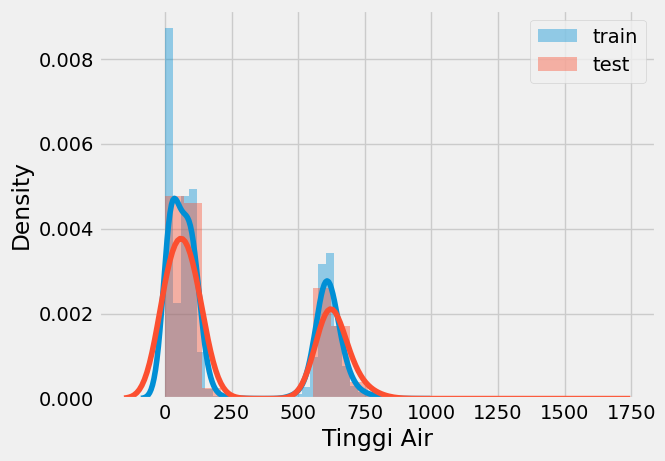

In [ ]:
sns.distplot(train["Tinggi Air"], label = "train")
sns.distplot(test["Tinggi Air"], label = "test")
plt.legend()

# Data Preprocessing

In [ ]:
def preprocess_train(df):
  # Membuat copy dataframe
  df = df.copy()

  # Melakukan encoding variabel kategorik
  df["Pintu Air"] = df["Pintu Air"].map({"Katulampa":1, "Depok":2, "Manggarai":3}).copy()

  # Melakukan imputasi dengan mean
  #imputer = SimpleImputer(strategy = "mean")
  #df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns, index = df.index)

  # Membagi data berdasarkan pintu air
  katulampa = df[df["Pintu Air"] == 1].copy()
  depok = df[df["Pintu Air"] == 2].copy()
  manggarai = df[df["Pintu Air"] == 3].copy()

  # Melakukan imputasi dengan median
  median_imputer = MeanMedianImputer(
                   imputation_method = 'median',
                   variables = ['Intensitas', 'Intensitas_lag_1',
                                'Intensitas_lag_2', 'Intensitas_Marina']
                   )
  katulampa = median_imputer.fit_transform(katulampa)
  depok = median_imputer.fit_transform(depok)
  manggarai = median_imputer.fit_transform(manggarai)

  # Melakukan imputasi dengan mean
  mean_imputer = MeanMedianImputer(
                   imputation_method = 'mean',
                   variables = ['Tinggi Air', 'Tinggi Air_lag_1', 'Tinggi Air_Marina',
                                'Tinggi Air_lag_2', 'Prediksi 6 Jam Ke Depan']
                   )
  katulampa = mean_imputer.fit_transform(katulampa)
  depok = mean_imputer.fit_transform(depok)
  manggarai = mean_imputer.fit_transform(manggarai)

  # Menggabungkan kembali df
  dummy = pd.concat([katulampa, depok], axis = 0)
  df = pd.concat([dummy, manggarai], axis = 0)

  return df

def preprocess_test(df):
  # Membuat copy dataframe
  df = df.copy()

  # Melakukan encoding variabel kategorik
  df["Pintu Air"] = df["Pintu Air"].map({"Katulampa":1, "Depok":2, "Manggarai":3})

  # Melakukan imputasi dengan mean
  #imputer = SimpleImputer(strategy = "mean")
  #df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns, index = df.index)

  # Membagi data berdasarkan pintu air
  katulampa = df[df["Pintu Air"] == 1].copy()
  depok = df[df["Pintu Air"] == 2].copy()
  manggarai = df[df["Pintu Air"] == 3].copy()

  # Melakukan imputasi dengan median
  median_imputer = MeanMedianImputer(
                   imputation_method = 'median',
                   variables = ['Intensitas', 'Intensitas_lag_1',
                                'Intensitas_lag_2', 'Intensitas_Marina']
                   )
  katulampa = median_imputer.fit_transform(katulampa)
  depok = median_imputer.fit_transform(depok)
  manggarai = median_imputer.fit_transform(manggarai)

  # Melakukan imputasi dengan mean
  mean_imputer = MeanMedianImputer(
                   imputation_method = 'mean',
                   variables = ['Tinggi Air', 'Tinggi Air_lag_1', 'Tinggi Air_Marina',
                                'Tinggi Air_lag_2']
                   )
  katulampa = mean_imputer.fit_transform(katulampa)
  depok = mean_imputer.fit_transform(depok)
  manggarai = mean_imputer.fit_transform(manggarai)

  # Menggabungkan kembali df
  dummy = pd.concat([katulampa, depok], axis = 0)
  df = pd.concat([dummy, manggarai], axis = 0)

  return df

In [ ]:
def preprocess_train(df):
  # Membuat copy dataframe
  df = df.copy()

  # Melakukan encoding variabel kategorik
  df["Pintu Air"] = df["Pintu Air"].map({"Katulampa":1, "Depok":2, "Manggarai":3}).copy()

  # Melakukan imputasi dengan mean
  #imputer = SimpleImputer(strategy = "mean")
  #df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns, index = df.index)

  # Membagi data berdasarkan pintu air
  katulampa = df[df["Pintu Air"] == 1].copy()
  depok = df[df["Pintu Air"] == 2].copy()
  manggarai = df[df["Pintu Air"] == 3].copy()

  # Melakukan imputasi dengan median
  median_imputer = MeanMedianImputer(
                   imputation_method = 'median',
                   variables = ['Intensitas', 'Intensitas_lag_1',
                                'Intensitas_lag_2', 'Intensitas_Marina']
                   )
  katulampa = median_imputer.fit_transform(katulampa)
  depok = median_imputer.fit_transform(depok)
  manggarai = median_imputer.fit_transform(manggarai)

  # Melakukan imputasi dengan mean
  mean_imputer = MeanMedianImputer(
                   imputation_method = 'mean',
                   variables = ['Tinggi Air_lag_1', 'Tinggi Air_Marina',
                                'Tinggi Air_lag_2']
                   )
  katulampa = mean_imputer.fit_transform(katulampa)
  depok = mean_imputer.fit_transform(depok)
  manggarai = mean_imputer.fit_transform(manggarai)

  # Menggabungkan kembali df
  dummy = pd.concat([katulampa, depok], axis = 0)
  df = pd.concat([dummy, manggarai], axis = 0)

  # Melakukan interpolasi
  df["Tinggi Air"] = df["Tinggi Air"].interpolate()
  df["Prediksi 6 Jam Ke Depan"] = df["Prediksi 6 Jam Ke Depan"].interpolate()

  return df

def preprocess_test(df):
  # Membuat copy dataframe
  df = df.copy()

  # Melakukan encoding variabel kategorik
  df["Pintu Air"] = df["Pintu Air"].map({"Katulampa":1, "Depok":2, "Manggarai":3})

  # Melakukan imputasi dengan mean
  #imputer = SimpleImputer(strategy = "mean")
  #df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns, index = df.index)

  # Membagi data berdasarkan pintu air
  katulampa = df[df["Pintu Air"] == 1].copy()
  depok = df[df["Pintu Air"] == 2].copy()
  manggarai = df[df["Pintu Air"] == 3].copy()

  # Melakukan imputasi dengan median
  median_imputer = MeanMedianImputer(
                   imputation_method = 'median',
                   variables = ['Intensitas', 'Intensitas_lag_1',
                                'Intensitas_lag_2', 'Intensitas_Marina']
                   )
  katulampa = median_imputer.fit_transform(katulampa).bfill()
  depok = median_imputer.fit_transform(depok).bfill()
  manggarai = median_imputer.fit_transform(manggarai).bfill()

  # Menggabungkan kembali df
  dummy = pd.concat([katulampa, depok], axis = 0)
  df = pd.concat([dummy, manggarai], axis = 0)

  return df

In [ ]:
def preprocess_train(df):
  # Membuat copy dataframe
  df = df.copy()

  # Melakukan encoding variabel kategorik
  df["Pintu Air"] = df["Pintu Air"].map({"Katulampa":1, "Depok":2, "Manggarai":3}).copy()

  # Melakukan imputasi dengan mean
  #imputer = SimpleImputer(strategy = "mean")
  #df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns, index = df.index)

  # Membagi data berdasarkan pintu air
  katulampa = df[df["Pintu Air"] == 1].copy()
  depok = df[df["Pintu Air"] == 2].copy()
  manggarai = df[df["Pintu Air"] == 3].copy()

  # Melakukan imputasi dengan median
  median_imputer = MeanMedianImputer(
                   imputation_method = 'median',
                   variables = ['Intensitas', 'Intensitas_Marina']
                   )
  katulampa = median_imputer.fit_transform(katulampa)
  depok = median_imputer.fit_transform(depok)
  manggarai = median_imputer.fit_transform(manggarai)

  # Melakukan imputasi dengan mean
  mean_imputer = MeanMedianImputer(
                   imputation_method = 'mean',
                   variables = ['Tinggi Air_Marina']
                   )
  katulampa = mean_imputer.fit_transform(katulampa)
  depok = mean_imputer.fit_transform(depok)
  manggarai = mean_imputer.fit_transform(manggarai)

  # Menggabungkan kembali df
  dummy = pd.concat([katulampa, depok], axis = 0)
  df = pd.concat([dummy, manggarai], axis = 0)

  # Melakukan interpolasi
  df["Tinggi Air"] = df["Tinggi Air"].interpolate()
  df["Prediksi 6 Jam Ke Depan"] = df["Prediksi 6 Jam Ke Depan"].interpolate()

  return df

def preprocess_test(df):
  # Membuat copy dataframe
  df = df.copy()

  # Melakukan encoding variabel kategorik
  df["Pintu Air"] = df["Pintu Air"].map({"Katulampa":1, "Depok":2, "Manggarai":3})

  # Melakukan imputasi dengan mean
  #imputer = SimpleImputer(strategy = "mean")
  #df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns, index = df.index)

  # Membagi data berdasarkan pintu air
  katulampa = df[df["Pintu Air"] == 1].copy()
  depok = df[df["Pintu Air"] == 2].copy()
  manggarai = df[df["Pintu Air"] == 3].copy()

  # Melakukan imputasi dengan median
  median_imputer = MeanMedianImputer(
                   imputation_method = 'median',
                   variables = ['Intensitas', 'Intensitas_Marina', 'Tinggi Air_Marina']
                   )
  katulampa = median_imputer.fit_transform(katulampa).bfill()
  depok = median_imputer.fit_transform(depok).bfill()
  manggarai = median_imputer.fit_transform(manggarai).bfill()

  # Menggabungkan kembali df
  dummy = pd.concat([katulampa, depok], axis = 0)
  df = pd.concat([dummy, manggarai], axis = 0)

  return df

In [ ]:
train = preprocess_train(df).bfill()
test = preprocess_test(dfs).bfill()

# Modelling and Evaluation

## Machine Learning

In [ ]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR

In [ ]:
# Membagi data train menjadi X dan y
X = train.dropna()
y = np.log(X.pop("Prediksi 6 Jam Ke Depan"))

In [ ]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
test_scaled = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

In [ ]:
# Membagi data menjadi training dan validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = X["Pintu Air"])

In [ ]:
estimators = []
estimators.append(("LR", LinearRegression()))
estimators.append(("LGBM", LGBMRegressor()))

In [ ]:
# Melakukan fitting, prediksi, dan evaluasi
model = VotingRegressor(estimators = estimators)
model.fit(X_train, y_train)
preds = model.predict(X_valid)
print(np.sqrt(mean_squared_error(np.exp(preds), np.exp(y_valid))))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9882
[LightGBM] [Info] Number of data points in the train set: 42002, number of used features: 52
[LightGBM] [Info] Start training from score 4.718981
30.391280647864054


In [ ]:
# Melakukan prediksi ke data testing
model = VotingRegressor(estimators = estimators)
model.fit(X, y)
preds = model.predict(test)
sub_preds["Prediksi 6 Jam Ke Depan"] = np.exp(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 52503, number of used features: 52
[LightGBM] [Info] Start training from score 4.719955


<ipython-input-211-84ca9cc785bb>:5: RuntimeWarning: overflow encountered in exp
  sub_preds["Prediksi 6 Jam Ke Depan"] = np.exp(preds)


<ipython-input-212-10948c61a628>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sub_preds["Prediksi 6 Jam Ke Depan"])


OverflowError: ignored

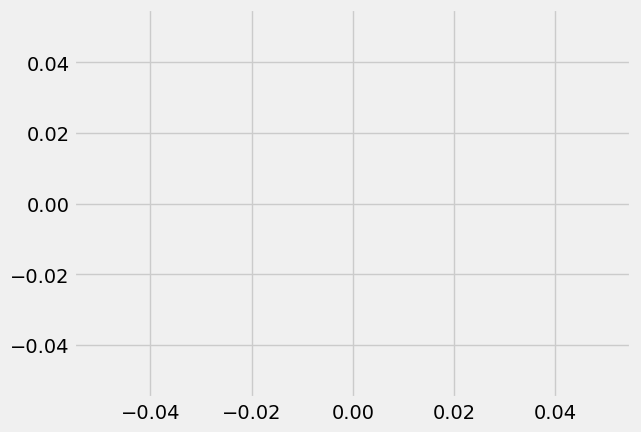

In [ ]:
sns.distplot(sub_preds["Prediksi 6 Jam Ke Depan"])

In [ ]:
sub_preds.describe()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Tinggi Air,ID,Prediksi 6 Jam Ke Depan
count,4230.000000,4248.000000,4.248000e+03
mean,253.401395,2832.000000,inf
std,273.978642,1635.248243,NaN
min,1.400000,1.000000,2.992403e+26
25%,27.200000,1416.500000,2.671070e+112
50%,96.000000,2832.000000,4.879924e+203
75%,605.000000,4247.500000,NaN
max,1592.000000,5663.000000,inf


In [ ]:
sub_preds

,Tinggi Air,ID,Prediksi 6 Jam Ke Depan
Waktu,,,
2023-01-01 00:00:00,20.0,2,21.192789
2023-01-01 01:00:00,46.5,6,26.442001
2023-01-01 02:00:00,55.7,10,25.880600
2023-01-01 03:00:00,59.7,14,26.480419
2023-01-01 04:00:00,52.4,18,21.740231
...,...,...,...
2023-02-28 19:00:00,NaN,5647,756.959394
2023-02-28 20:00:00,NaN,5651,756.746001
2023-02-28 21:00:00,NaN,5655,763.963349


In [ ]:
np.sqrt(mean_squared_error(sub_preds.dropna()["Prediksi 6 Jam Ke Depan"], sub_preds.dropna()["Tinggi Air"]))

60.20719908638308

In [ ]:
katulampa = sub_preds.iloc[:1416]
depok = sub_preds.iloc[1416:(1416*2)]
manggarai = sub_preds.iloc[(1416*2):]

In [ ]:
np.sqrt(mean_squared_error(katulampa.dropna()["Prediksi 6 Jam Ke Depan"], katulampa.dropna()["Tinggi Air"]))

10.220498650794053

In [ ]:
sub = pd.merge(sub, sub_preds, on = "ID").drop("Tinggi Air", axis = 1)
sub.rename(columns = {"Prediksi 6 Jam Ke Depan":"PREDIKSI"}, inplace = True)
sub.to_csv("lgbm_tuned_window.csv", index = False)

In [ ]:
actual = sub_preds.iloc[6:, :][["Tinggi Air", "Prediksi 6 Jam Ke Depan"]]

In [ ]:
sub_preds.drop(["Tinggi Air", "Prediksi 6 Jam Ke Depan"], axis = 1, inplace = True)

In [ ]:
subs = pd.concat([sub_preds.reset_index(drop = True), actual.reset_index(drop = True)], axis = 1)

In [ ]:
subs

,ID,Tinggi Air,Prediksi 6 Jam Ke Depan
0,2,20.0,59.981865
1,6,46.5,121.285744
2,10,55.7,74.854836
3,14,59.7,42.747471
4,18,52.4,46.851849
...,...,...,...
4243,5647,NaN,NaN
4244,5651,NaN,NaN
4245,5655,NaN,NaN
4246,5659,NaN,NaN


In [ ]:
sub = pd.merge(sub, subs, on = "ID").fillna(subs["Prediksi 6 Jam Ke Depan"].mean().round(0))
sub["Prediksi 6 Jam Ke Depan"] = sub["Prediksi 6 Jam Ke Depan"].astype("int")

In [ ]:
sub.drop(["Tinggi Air"], axis = 1, inplace = True)

In [ ]:
sub.rename(columns = {"Prediksi 6 Jam Ke Depan":"PREDIKSI"}, inplace = True)

In [ ]:
sub["PREDIKSI"] = sub["PREDIKSI"].apply(lambda x: sub["PREDIKSI"].mean() if x <= 0 else x)

In [ ]:
sub.to_csv("baseline_fix_bgt.csv", index = False)

## Deep Learning

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

def plot_model_rmse_and_loss(history):

    # Evaluate train and validation accuracies and losses

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize epochs vs. train and validation accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

In [ ]:
katulampa = train[train["Pintu Air"] == 1].copy()
depok = train[train["Pintu Air"] == 2].copy()
manggarai = train[train["Pintu Air"] == 3].copy()

In [ ]:
train_end_idx = int(0.8*len(katulampa))
cv_end_idx = int(0.1*len(katulampa)) + int(0.8*len(katulampa))
test_end_idx = int(len(katulampa))

In [ ]:
X = katulampa[katulampa.columns.drop(["Prediksi 6 Jam Ke Depan"])].values
y = katulampa["Prediksi 6 Jam Ke Depan"].values
y = y.reshape(-1, 1)

In [ ]:
scaler_X = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

In [ ]:
X_norm = pd.DataFrame(scaler_X.fit_transform(X))
y_norm = pd.DataFrame(scaler_y.fit_transform(y))

In [ ]:
dataset_norm = np.concatenate((X_norm, y_norm), axis = 1)
past_history = 24
future_target = 0

In [ ]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)

X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)

X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

In [ ]:
X_train = X_train[:, :, :-1]
X_val = X_val[:, :, :-1]
X_test = X_test[:, :, :-1]

In [ ]:
batch_size = 32
buffer_size = 1000

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [ ]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [ ]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [ ]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    Bidirectional(LSTM(200, input_shape = input_shape,
         return_sequences = True)),
    Bidirectional(LSTM(200, input_shape = input_shape,
         return_sequences = True)),
    Flatten(),
    Dense(200, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate = 6e-3, amsgrad = True)

multivariate_lstm.compile(loss = loss,
                          optimizer = optimizer,
                          metrics = metric)

In [ ]:
history = multivariate_lstm.fit(train, epochs = 200,
                                validation_data = validation,
                                callbacks = early_stopping)

Epoch 1/200
437/437 [==============================] - 17s 17ms/step - loss: 4.8625 - root_mean_squared_error: 2.0806 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916
Epoch 2/200
437/437 [==============================] - 5s 11ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 3/200
437/437 [==============================] - 6s 13ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 4/200
437/437 [==============================] - 6s 14ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 5/200
437/437 [==============================] - 6s 14ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 6/200
437/437 [==============================] - 6s 13ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 

In [ ]:
forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))

print('RMSE of hour-ahead electricity load LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

54/54 [==============================] - 2s 6ms/step
RMSE of hour-ahead electricity load LSTM forecast: 10.818


In [ ]:
def transform_data(dataset, start_index, end_index, history_size,
                      target_size, step):
    data = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

    return np.array(data)

In [ ]:
katulampa_test = test[test["Pintu Air"] == 1].copy()
depok_test = test[test["Pintu Air"] == 2].copy()
manggarai_test = test[test["Pintu Air"] == 3].copy()

In [ ]:
katulampa_test = test[test["Pintu Air"] == 1].copy()
depok_test = test[test["Pintu Air"] == 2].copy()
manggarai_test = test[test["Pintu Air"] == 2].copy()

In [ ]:
katulampa_test = test[test["Pintu Air"] == 1].copy()
depok_test = test[test["Pintu Air"] == 2].copy()
manggarai_test = test[test["Pintu Air"] == 1].copy()

In [ ]:
manggarai_test

,Pintu Air,Tinggi Air,Intensitas,hour,dayofweek,dayofyear,dayofmonth,week,quarter,month,year,Tinggi Air_lag_1,Tinggi Air_lag_2,Intensitas_lag_1,Intensitas_lag_2,Tinggi Air_Marina,Intensitas_Marina
0,1,20.0,0.0,0,6,1,1,52,1,1,2023,20.0,20.0,0.0,0.0,159.0,0.0
1,1,34.6,0.0,1,6,1,1,52,1,1,2023,20.0,20.0,0.0,0.0,163.0,0.0
2,1,35.3,0.0,2,6,1,1,52,1,1,2023,34.6,20.0,0.0,0.0,176.0,0.0
3,1,36.3,0.0,3,6,1,1,52,1,1,2023,35.3,34.6,0.0,0.0,187.0,0.0
4,1,20.0,0.0,4,6,1,1,52,1,1,2023,36.3,35.3,0.0,0.0,194.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,1,53.1,6.0,19,1,59,28,9,1,2,2023,54.4,56.9,6.0,6.0,NaN,0.0
1412,1,51.6,6.0,20,1,59,28,9,1,2,2023,53.1,54.4,6.0,6.0,NaN,0.0
1413,1,50.2,6.0,21,1,59,28,9,1,2,2023,51.6,53.1,6.0,6.0,NaN,0.0
1414,1,49.3,6.0,22,1,59,28,9,1,2,2023,50.2,51.6,6.0,6.0,NaN,0.0


In [ ]:
manggarai_test_norm = scaler_X.fit_transform(manggarai_test)

In [ ]:
manggarai_test_norm_tf = transform_data(manggarai_test_norm, 0, len(manggarai_test_norm), past_history, future_target, step = 1)

In [ ]:
forecast = multivariate_lstm.predict(manggarai_test_norm_tf)
lstm_forecast = scaler_y.inverse_transform(forecast)

44/44 [==============================] - 0s 6ms/step


In [ ]:
preds = lstm_forecast.flatten()

In [ ]:
preds

array([41.46267 , 31.409647, 27.185856, ...,       nan,       nan,
             nan], dtype=float32)

In [ ]:
manggarai_preds = sub_preds[:1416]

In [ ]:
manggarai_preds = manggarai_preds[24:].reset_index(drop = True)

In [ ]:
manggarai_preds["Prediksi 6 Jam Ke Depan"] = np.abs(preds)

In [ ]:
manggarai_preds = manggarai_preds.iloc[:-6]

In [ ]:
print(np.sqrt(mean_squared_error(manggarai_preds.dropna()["Prediksi 6 Jam Ke Depan"], manggarai_preds.dropna()["Tinggi Air"])))

11.727707336740291


In [ ]:
multivariate_lstm.save_weights("multivariate_lstm_v2.h5")

In [ ]:
temp = katulampa
dataset = temp["Prediksi 6 Jam Ke Depan"].dropna().values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset),:]

def create_dataset(dataset, label, look_back = 25):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10)

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = loss, optimizer = 'adam', metrics = metric)
history = model.fit(X_train, Y_train, epochs = 200, batch_size = 70, validation_data=(X_test, Y_test),verbose=1, shuffle = False, callbacks = [early_stopping])
model.summary()

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

109/109 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 3.849085044002367
Train Root Mean Squared Error: 5.995495453380326
Test Mean Absolute Error: 4.171954216058945
Test Root Mean Squared Error: 6.486940694664884


In [ ]:
# generate the forecasts
X_ = scaler.fit_transform(temp[["Prediksi 6 Jam Ke Depan"]].dropna().values[-25:]).flatten()  # last available input sequence
X_ = X_.reshape(1, 1, 25)
n_forecast = 1000
y_forecast = []

for i in range(n_forecast):
  Y_ = model.predict(X_).reshape(-1, 1)
  X_ = X_.reshape(1, 25)
  X_ = np.append(X_, Y_)
  X_ = X_[1:].reshape(1, 1, 25)
  y_forecast.append(Y_)

y_forecast = np.array(y_forecast)

In [ ]:
y_forecast = y_forecast.flatten().reshape(-1, 1)
y_forecast = scaler.inverse_transform(y_forecast)

In [ ]:
y_forecast.flatten()

array([69.41417 , 61.507626, 58.942017, 58.34738 , 60.489407, 63.007027,
       65.73985 , 70.07858 , 73.05896 , 72.30354 , 66.119514, 62.63675 ,
       60.836   , 58.966576, 57.10696 , 57.19501 , 61.612053, 65.32226 ,
       68.37216 , 66.798584, 65.33161 , 63.687145, 60.99955 , 58.18446 ,
       56.00502 , 55.46721 , 56.15933 , 57.04799 , 58.110123, 59.232914,
       60.15771 , 60.313534, 59.083412, 57.362877, 55.811512, 54.969536,
       54.41324 , 54.239223, 54.671036, 55.530323, 56.445232, 56.76007 ,
       56.585476, 56.024426, 55.34187 , 54.567764, 53.84217 , 53.409107,
       53.358246, 53.57632 , 53.91232 , 54.234196, 54.5085  , 54.628975,
       54.48708 , 54.107464, 53.624046, 53.232296, 52.98245 , 52.884712,
       52.916378, 53.06999 , 53.286884, 53.458496, 53.51335 , 53.434406,
       53.26772 , 53.054802, 52.838726, 52.66457 , 52.573143, 52.573997,
       52.64127 , 52.731945, 52.814922, 52.86353 , 52.858685, 52.791096,
       52.676037, 52.550472, 52.447765, 52.386887, 

# Conclusion